Certainly! Below is a comprehensive guide to forecasting Bitcoin prices using a multi-layer LSTM model in PyTorch. We'll follow each of the outlined steps, from data acquisition to model training and evaluation. Finally, we'll discuss the implications of varying the number of previous data points used for predictions.

---

## **1. Library Installation**

First, ensure that all necessary libraries are installed. You can install them using `pip` if they're not already available in your environment.

```bash
!pip install yfinance
!pip install scikit-learn
!pip install matplotlib
!pip install torch
```

---

## **2. Data Download**

We'll use the `yfinance` library to download Bitcoin price data. The symbol for Bitcoin in USD is `"BTC-USD"`. We'll fetch data from `2019-01-01` to `2024-01-01` for training and data after `2024-01-01` for testing.

```python
import yfinance as yf
import pandas as pd

# Define the Bitcoin ticker symbol
btc_symbol = 'BTC-USD'

# Define the date ranges
train_start = '2019-01-01'
train_end = '2024-01-01'
test_start = '2024-01-02'
test_end = '2024-12-31'  # Assuming we have data up to this date

# Download training data
train_data = yf.download(btc_symbol, start=train_start, end=train_end)

# Download testing data
test_data = yf.download(btc_symbol, start=test_start, end=test_end)

# Display the first few rows of training data
print(train_data.head())
```

**Note:** If you don't have access to data beyond `2024-01-01`, adjust the `test_start` and `test_end` accordingly.

---

## **3. Plotting Data**

To verify the data download, we'll plot the closing prices, differentiating between training and testing datasets with distinct colors.

```python
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data['Close'], label='Testing Data', color='orange')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()
```

---

## **4. Data Normalization**

Normalization helps in speeding up the training process and achieving better performance. We'll use `MinMaxScaler` to scale the closing prices between 0 and 1, based solely on the training data to prevent data leakage.

```python
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training data and transform
train_scaled = scaler.fit_transform(train_data[['Close']])

# Transform the testing data using the same scaler
test_scaled = scaler.transform(test_data[['Close']])

# Verify the scaling
print(f"Training data scaled shape: {train_scaled.shape}")
print(f"Testing data scaled shape: {test_scaled.shape}")
```

---

## **5. Data Preparation**

We'll prepare the data for the LSTM model by creating sequences of previous data points to predict the next value. Here, we'll use 60 previous time steps for each prediction.

```python
import numpy as np

def create_sequences(data, seq_length):
    """
    Create sequences of data for LSTM.

    Args:
    - data (numpy.ndarray): Scaled data.
    - seq_length (int): Number of previous time steps to use.

    Returns:
    - X (numpy.ndarray): Feature sequences.
    - y (numpy.ndarray): Targets.
    """
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Define sequence length
SEQ_LENGTH = 60

# Create training sequences
X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH)

# Create testing sequences
X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH)

# Reshape the data to fit LSTM input requirements
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")  # Expected: (1766, 60, 1)
print(f"y_train shape: {y_train.shape}")  # Expected: (1766,)
```

---

## **6. Model Creation**

We'll use the modified PyTorch LSTM model you provided earlier. Here's the complete implementation:

```python
import torch
import torch.nn as nn

class BitcoinPricePredictor(nn.Module):
    def __init__(self, input_size=1, lstm_units=50, num_layers=5, dropout_rate=0.2):
        """
        A multi-layer LSTM model with Dropout for Bitcoin price prediction.

        Args:
        - input_size: Number of features in the input data.
        - lstm_units: Number of units in each LSTM layer.
        - num_layers: Number of LSTM layers in the model.
        - dropout_rate: Dropout rate to be applied after each LSTM layer.
        """
        super(BitcoinPricePredictor, self).__init__()
        self.num_layers = num_layers
        self.lstm_units = lstm_units
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=lstm_units,
            num_layers=num_layers,
            dropout=dropout_rate,
            batch_first=True
        )
        
        # Fully connected layer to output predictions
        self.fc = nn.Linear(lstm_units, 1)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.lstm_units).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.lstm_units).to(x.device)
        
        # Forward propagate through LSTM layers
        out, _ = self.lstm(x, (h0, c0))
        
        # Pass the output of the last time step to the fully connected layer
        out = self.fc(out[:, -1, :])  # out[:, -1, :] -> get the output of the last time step
        return out
```

---

## **7. Model Training**

We'll set up the training process using the Mean Squared Error (MSE) loss function and the Adam optimizer. The model will be trained for 100 epochs with a batch size of 32.

```python
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# Create TensorDataset and DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BitcoinPricePredictor(input_size=1, lstm_units=50, num_layers=5, dropout_rate=0.2).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.6f}")
```
---

## **8. Prediction and Plotting**

After training, we'll make predictions on the test data and plot them alongside the actual values to visualize the model's performance.

```python
# Set model to evaluation mode
model.eval()

with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    predictions = model(X_test_tensor).cpu().numpy()

# Inverse transform the predictions and actual values
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a date range for plotting
test_dates = test_data.index[SEQ_LENGTH:]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_inverse, label='Actual Prices', color='blue')
plt.plot(test_dates, predictions_inverse, label='Predicted Prices', color='red')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
```

**Visualization:**

The plot will display actual Bitcoin prices in blue and the model's predicted prices in red over the test period. This visual comparison helps assess the model's accuracy and identify any patterns it might have missed.

---

## **Advantages and Disadvantages of Varying the Number of Previous Data Points**

**Variable in Focus:** *Number of Previous Data Points (Sequence Length)*

**Implications of Increasing the Sequence Length:**

### **Advantages:**

1. **Capturing Long-Term Dependencies:**
   - **Benefit:** Longer sequences allow the model to learn from extended historical patterns, potentially capturing trends and cycles that shorter sequences might miss.
   
2. **Enhanced Feature Representation:**
   - **Benefit:** More data points provide a richer context, enabling the model to discern more complex relationships in the data.

3. **Potentially Improved Performance:**
   - **Benefit:** With more information, the model might achieve higher accuracy in predictions, especially if the underlying data has long-term dependencies.

### **Disadvantages:**

1. **Increased Computational Complexity:**
   - **Drawback:** Longer sequences require more memory and computational power, leading to longer training times and higher resource consumption.

2. **Risk of Overfitting:**
   - **Drawback:** With more input data, the model might become too tailored to the training data, reducing its ability to generalize to unseen data.

3. **Diminishing Returns:**
   - **Drawback:** Beyond a certain point, adding more data points may not yield significant performance improvements and might even introduce noise.

4. **Handling Vanishing Gradients:**
   - **Drawback:** Especially in RNN-based architectures like LSTM, very long sequences can exacerbate vanishing gradient problems, making it harder for the model to learn long-term dependencies effectively.

**Implications of Decreasing the Sequence Length:**

### **Advantages:**

1. **Reduced Computational Load:**
   - **Benefit:** Shorter sequences require less memory and faster processing, enabling quicker training and inference.

2. **Mitigated Overfitting:**
   - **Benefit:** With fewer input points, the model is less likely to memorize the training data, promoting better generalization.

3. **Simpler Model Dynamics:**
   - **Benefit:** Easier for the model to learn and capture essential patterns without being bogged down by excessive historical data.

### **Disadvantages:**

1. **Missing Long-Term Patterns:**
   - **Drawback:** Shorter sequences might not capture essential trends or cycles, leading to poorer predictive performance in scenarios where long-term dependencies are crucial.

2. **Limited Context:**
   - **Drawback:** The model has less historical information to base its predictions on, which might be insufficient for accurate forecasting in volatile markets like cryptocurrency.

3. **Potential Underfitting:**
   - **Drawback:** If the sequence length is too short, the model might not have enough information to learn meaningful patterns, resulting in lower accuracy.

---

**Conclusion:**

Selecting the optimal number of previous data points is a balance between providing sufficient historical context for the model to learn meaningful patterns and managing computational resources effectively. It's essential to experiment with different sequence lengths, possibly using techniques like cross-validation, to determine the best configuration for your specific dataset and prediction goals.

---

**Feel free to reach out if you need further assistance or modifications!**

In [4]:
!pip install yfinance
!pip install scikit-learn
!pip install matplotlib
!pip install torch


In [5]:
import yfinance as yf
import pandas as pd

# Define the Bitcoin ticker symbol
btc_symbol = 'BTC-USD'

# Define the date ranges
train_start = '2019-01-01'
train_end = '2024-01-01'
test_start = '2024-01-02'
test_end = '2024-12-31'  # Assuming we have data up to this date

# Download training data
train_data = yf.download(btc_symbol, start=train_start, end=train_end)

# Download testing data
test_data = yf.download(btc_symbol, start=test_start, end=test_end)

# Display the first few rows of training data
print(train_data.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price                        Adj Close        Close         High          Low  \
Ticker                         BTC-USD      BTC-USD      BTC-USD      BTC-USD   
Date                                                                            
2019-01-01 00:00:00+00:00  3843.520020  3843.520020  3850.913818  3707.231201   
2019-01-02 00:00:00+00:00  3943.409424  3943.409424  3947.981201  3817.409424   
2019-01-03 00:00:00+00:00  3836.741211  3836.741211  3935.685059  3826.222900   
2019-01-04 00:00:00+00:00  3857.717529  3857.717529  3865.934570  3783.853760   
2019-01-05 00:00:00+00:00  3845.194580  3845.194580  3904.903076  3836.900146   

Price                             Open      Volume  
Ticker                         BTC-USD     BTC-USD  
Date                                                
2019-01-01 00:00:00+00:00  3746.713379  4324200990  
2019-01-02 00:00:00+00:00  3849.216309  5244856836  
2019-01-03 00:00:00+00:00  3931.048584  4530215219  
2019-01-04 00:00:00+00:00  3832.0

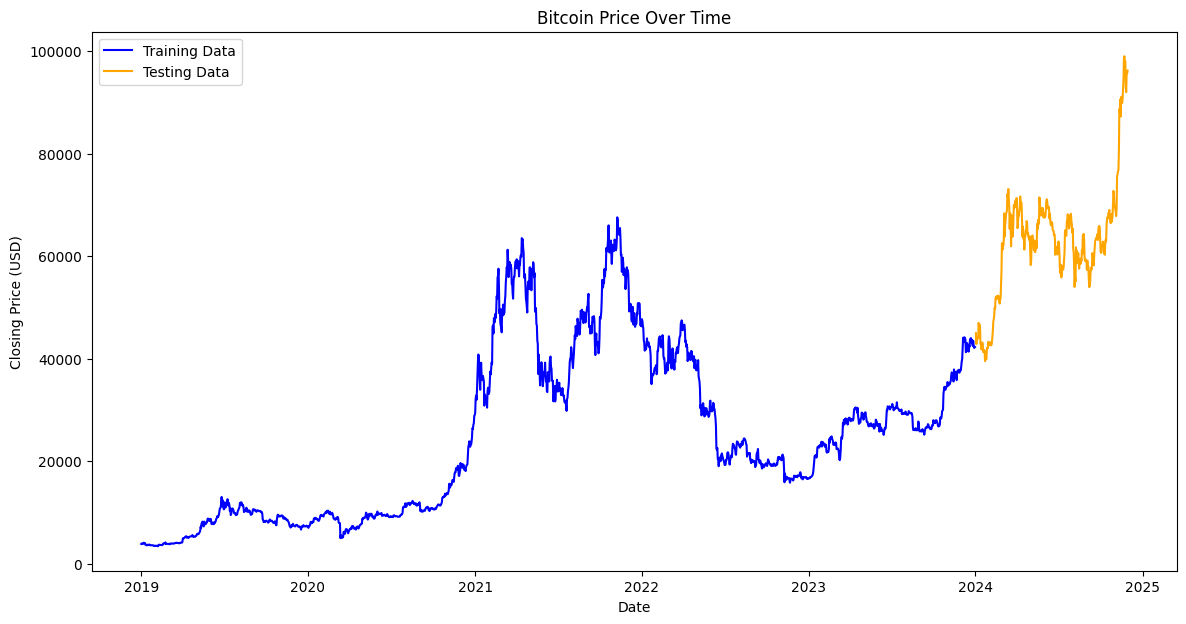

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data['Close'], label='Testing Data', color='orange')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training data and transform
train_scaled = scaler.fit_transform(train_data[['Close']])

# Transform the testing data using the same scaler
test_scaled = scaler.transform(test_data[['Close']])

# Verify the scaling
print(f"Training data scaled shape: {train_scaled.shape}")
print(f"Testing data scaled shape: {test_scaled.shape}")


Training data scaled shape: (1826, 1)
Testing data scaled shape: (333, 1)


In [8]:
import numpy as np

def create_sequences(data, seq_length):
    """
    Create sequences of data for LSTM.

    Args:
    - data (numpy.ndarray): Scaled data.
    - seq_length (int): Number of previous time steps to use.

    Returns:
    - X (numpy.ndarray): Feature sequences.
    - y (numpy.ndarray): Targets.
    """
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Define sequence length
SEQ_LENGTH = 60

# Create training sequences
X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH)

# Create testing sequences
X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH)

# Reshape the data to fit LSTM input requirements
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")  # Expected: (1766, 60, 1)
print(f"y_train shape: {y_train.shape}")  # Expected: (1766,)


X_train shape: (1766, 60, 1)
y_train shape: (1766,)


In [9]:
import torch
import torch.nn as nn

class BitcoinPricePredictor(nn.Module):
    def __init__(self, input_size=1, lstm_units=50, num_layers=5, dropout_rate=0.2):
        """
        A multi-layer LSTM model with Dropout for Bitcoin price prediction.

        Args:
        - input_size: Number of features in the input data.
        - lstm_units: Number of units in each LSTM layer.
        - num_layers: Number of LSTM layers in the model.
        - dropout_rate: Dropout rate to be applied after each LSTM layer.
        """
        super(BitcoinPricePredictor, self).__init__()
        self.num_layers = num_layers
        self.lstm_units = lstm_units

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=lstm_units,
            num_layers=num_layers,
            dropout=dropout_rate,
            batch_first=True
        )

        # Fully connected layer to output predictions
        self.fc = nn.Linear(lstm_units, 1)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.lstm_units).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.lstm_units).to(x.device)

        # Forward propagate through LSTM layers
        out, _ = self.lstm(x, (h0, c0))

        # Pass the output of the last time step to the fully connected layer
        out = self.fc(out[:, -1, :])  # out[:, -1, :] -> get the output of the last time step
        return out


In [10]:
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# Create TensorDataset and DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BitcoinPricePredictor(input_size=1, lstm_units=50, num_layers=5, dropout_rate=0.2).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.6f}")


Epoch [10/100], Loss: 0.001847
Epoch [20/100], Loss: 0.001374
Epoch [30/100], Loss: 0.001200
Epoch [40/100], Loss: 0.000909
Epoch [50/100], Loss: 0.000792
Epoch [60/100], Loss: 0.000646
Epoch [70/100], Loss: 0.000661
Epoch [80/100], Loss: 0.000570
Epoch [90/100], Loss: 0.000581
Epoch [100/100], Loss: 0.000534


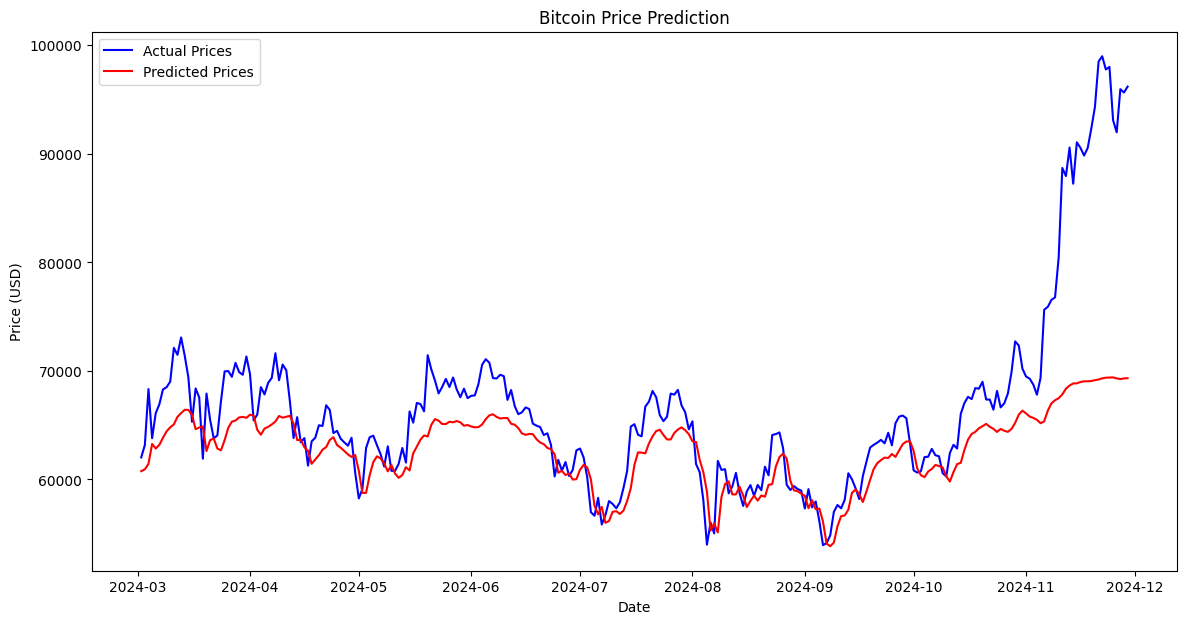

In [11]:
# Set model to evaluation mode
model.eval()

with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    predictions = model(X_test_tensor).cpu().numpy()

# Inverse transform the predictions and actual values
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a date range for plotting
test_dates = test_data.index[SEQ_LENGTH:]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_inverse, label='Actual Prices', color='blue')
plt.plot(test_dates, predictions_inverse, label='Predicted Prices', color='red')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
